<a href="https://colab.research.google.com/github/virenemmanuel/BizCardX-Extracting-Business-Card-Data-with-OCR/blob/main/BizCardX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install easyocr

In [ ]:
! pip install streamlit

In [ ]:
! pip install streamlit_option_menu

In [45]:
import streamlit as st
from streamlit_option_menu import option_menu
import easyocr
from PIL import Image
import pandas as pd
import numpy as np
import re


In [64]:
def image_to_text(path):

    input_image = Image.open(path)

    # Converting Image to array:
    image_array = np.array(input_image)

    reader = easyocr.Reader(['en'])
    text = reader.readtext(image_array, detail = 0)

    return text, input_image


In [75]:
image_to_text("/content/1.png")

(['Selva',
  'DATA MANAGER',
  '+123-456-7890',
  '+123-456-7891',
  'WWW XYZI.com',
  'hello@XYZ1.com',
  '123 ABC St , Chennai;',
  'selva',
  'TamilNadu 600113',
  'digitals'],
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1004x590>)

In [70]:
text_image, input_image = image_to_text("/content/1.png")

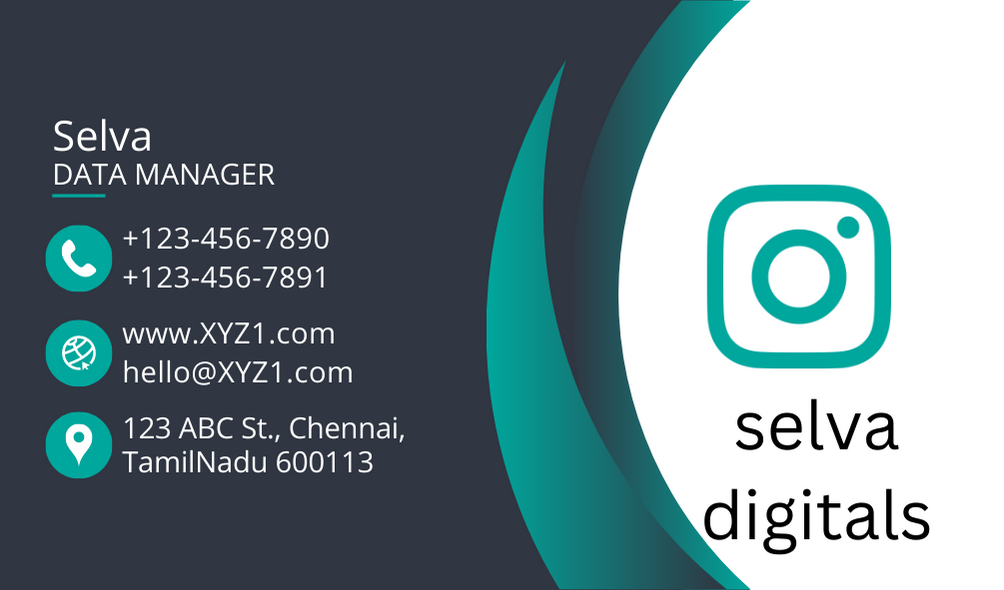

In [71]:
input_image

In [67]:
text_image

['REVANTH',
 'Marketing Executive',
 '123 ABC St,, HYDRABAD, TamilNadu;',
 '600001',
 '+91-456-1234',
 'hello@CHRISTMAS.com',
 'Family',
 'wwW.CHRISTMAS.com',
 'Restaurant']

In [72]:
image_array

array([[[ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        [ 48,  54,  66, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[ 48

In [73]:
def extracted_text(texts):

  extracted_dict = {"NAME":[],"DESIGNATION":[],
                    "COMPANY_NAME":[],"CONTACT_NO":[],
                    "EMAIL_ADD":[],"WEBSITE":[],
                    "ADDRESS":[],"PIN_CODE":[]}

  extracted_dict["NAME"].append(texts[0])
  extracted_dict["DESIGNATION"].append(texts[1])

  for i in range(2,len(texts)):

    if texts[i].startswith("+") or (texts[i].replace("-","").isdigit() and '-' in texts[i]):

       extracted_dict["CONTACT_NO"].append(texts[i])

    elif "@" in texts[i] or ".com" in texts[i]:
      extracted_dict["EMAIL_ADD"].append(texts[i])

    elif "WWW" in texts[i] or "www" in texts[i] or "Www" in texts[i] or "wWw" in texts[i] or "wwW" in texts[i]:
      small = texts[i].lower()
      extracted_dict["WEBSITE"].append(small)

    elif "Tamil Nadu" in texts[i] or "TamilNadu" in texts[i] or texts[i].isdigit():
      extracted_dict["PIN_CODE"].append(texts[i])

    elif re.match(r'^[A-Za-z]',texts[i]):
      extracted_dict["COMPANY_NAME"].append(texts[i])

    else:
      remove_colone = re.sub('r[,;]','',texts[i])
      extracted_dict["ADDRESS"].append(remove_colone)

  return extracted_dict



In [74]:
extracted_text(text_image)

{'NAME': ['Selva'],
 'DESIGNATION': ['DATA MANAGER'],
 'COMPANY_NAME': ['selva', 'digitals'],
 'CONTACT_NO': ['+123-456-7890', '+123-456-7891'],
 'EMAIL_ADD': ['WWW XYZI.com', 'hello@XYZ1.com'],
 'WEBSITE': [],
 'ADDRESS': ['123 ABC St , Chennai;'],
 'PIN_CODE': ['TamilNadu 600113']}